# **Problema das 8 Rainhas**

## **Equipe:**
- Jeferson Severino de Araújo
- Maria Luísa dos Santos Silva
  

**## Parte 1**

- Representação (genótipo): Permutação de string de bits.
  - Cada indivíduo será uma lista de 8 strings de 3 bits.
  - Cada string de 3 bits representa um número de 1 a 8 (coluna da rainha de uma linha).
- Recombinação: “cut-and-crossfill” crossover
- Probabilidade de Recombinação: 90%
- Mutação: escolher dois genes e trocá-los
- Probabilidade de Mutação: 40%
- Seleção de pais: ranking - Melhor de 2 de 5 escolhidos aleatoriamente
- Seleção de sobreviventes: substituição do pior
- Tamanho da população: 100
- Número de filhos gerados: 2
- Inicialização: aleatória
- Condição de término: Encontrar a solução, ou 10.000 avaliações de fitness
- Fitness: número de pares de rainhas que não se atacam

In [22]:
TOTAL_RUN_TIMES = 30
POPULATION_SIZE = 100
NUM_CHILDREN = 2
NUM_PARENTS = 2
MAX_NUM_ITERATIONS = 10000
CROSSOVER_PROBABILITY = 0.9
MUTATION_PROBABILITY = 0.4
NUMBER_OF_CROSSOVERS = 1 # Gera 2 filhos por iteração
SELECTION_SIZE = 5

In [23]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class GA:
    def __init__(self, objective):
        self.objective = objective

    def initialize_population(self):
        permutation = [str(bin(i)) for i in range(1,9)]
        population = [random.sample(permutation, 8) for _ in range(POPULATION_SIZE)]
        return population

    def fitness(self, individual):
        # Número de pares de rainhas que não se atacam
        # Máximo = 28 (C(8,2) = 8! / (2! * (8 - 2)!) = 28)
        # Mínimo = 0
        fitness = 28
        for i in range(8):
            for j in range(i + 1, 8):
                if individual[i] == individual[j]: # mesma coluna (duas linhas iguais)
                    fitness -= 1
                # mesma diagonal (diferença entre as linhas é igual à diferença entre as colunas)
                offset = j - i
                if abs(int(individual[i], 2) - int(individual[j], 2)) == offset:
                    fitness -= 1
                
        return fitness
    
    def survival_selection(self, population):
        # Sobreviventes = 100 melhores
        population.sort(key=lambda individual: self.fitness(individual), reverse=True)
        return population[0:POPULATION_SIZE]


    def mutation(self, population):
        # Escolhe dois genes aleatórios e troca os valores
        for individual in population:
            if random.random() < MUTATION_PROBABILITY:
                gene1, gene2 = random.sample(range(8), 2)
                individual[gene1], individual[gene2] = individual[gene2], individual[gene1]
        return population

    def find_solution(self, population):
        num_iterations = 0
        iteration_converged = 0
        fitness_mean = []
        best_fitness = []
        while num_iterations < MAX_NUM_ITERATIONS:
            for _ in  range(NUMBER_OF_CROSSOVERS):
                parents = self.parents_selection(population)
                children = parents
                if random.random() < CROSSOVER_PROBABILITY:
                    children = self.crossover(parents)
                children = self.mutation(children)
                population.extend(children)
            population = self.survival_selection(population)
            
            converged_individuals, fit_mean, best_fit = self.analyze_solution(population)
            fitness_mean.append(fit_mean)
            best_fitness.append(best_fit)

            num_iterations += 1
            if converged_individuals >= self.objective:
                break

        return population, num_iterations, fitness_mean, best_fitness

    def analyze_solution(self, population):
        # Calcula o fitness médio, max e mínimo
        fitness_sum = 0
        fitness_max = 0
        converged_individuals = 0

        for individual in population:
            individual_fitness = self.fitness(individual)
            fitness_sum += individual_fitness
            if individual_fitness > fitness_max:
                fitness_max = individual_fitness
            if individual_fitness == 28:
                converged_individuals += 1

        return converged_individuals, (fitness_sum / POPULATION_SIZE), fitness_max

    def execute(self):
        converged_executions_count = 0
        iterations_per_execution = []
        converged_per_execution = []
        fit_mean_per_execution = []

        for _ in range(TOTAL_RUN_TIMES):
            initial_population = self.initialize_population()
            population, num_iterations, fit_mean, best_fit = self.find_solution(initial_population)
            iterations_per_execution.append(num_iterations)
            converged_count, fitness_mean, _ = self.analyze_solution(population)
            converged_executions_count += 1 if converged_count >= self.objective else 0
            converged_per_execution.append(converged_count)
            fit_mean_per_execution.append(fitness_mean)

        print('Número de execuções convergidas: ', converged_executions_count)
        print ('Indivíduos que convergiram por execução:', converged_per_execution)
        
        # self.plot_graph(converged_per_execution, 'Número de execuções convergidas', 'Execução', 'Número de execuções convergidas')
        
        # Informações sobre iterações e média
        self.plot_graph(iterations_per_execution, 'Número de iterações por execução', 'Execução', 'Número de iterações', 'bar')

        # Média do fitness por iteração
        self.plot_graph(fit_mean_per_execution, 'Fitness médio por execução', 'Execução', 'Fitness médio', 'bar')
        
        # Melhor indivíduo por iteração
        self.plot_graph(best_fit, 'Melhor indivíduo por iteração', 'Iteração', 'Fitness')

        # Fitness médio por iteração
        self.plot_graph(fit_mean, 'Fitness médio por iteração', 'Iteração', 'Fitness médio')

    

    def plot_graph(self, y, title, x_label, y_label, type='line'):
        mean = np.mean(y)
        std = np.std(y)

        print(title)
        print('Média: ', mean)
        print('Desvio padrão: ', std)

        sns.set_style("darkgrid")
        plt.figure(figsize=(12, 4))
        if type == 'bar':
            plt.bar(range(1,len(y)+1), y, color='#6141ac')
        else:
            plt.plot(y, color='#6141ac', linewidth=2)
        plt.axhline(y=mean, color='#0097b2', linestyle='--')
        plt.axhline(y=mean + std, color='#0097b2', linestyle='--')
        plt.axhline(y=mean - std, color='#0097b2', linestyle='--')
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        
        plt.show()

    def parents_selection(self, population):
        # Pais = 2 melhores de 5
        selected = random.sample(population, SELECTION_SIZE)
        selected.sort(key=lambda individual: self.fitness(individual), reverse=True)
        return selected[0:NUM_PARENTS]

    def crossover(self, parents):
        # Cut and crossfill
        children = []
        cross_point = random.randint(1, 7)
        
        par1_cross = parents[1][cross_point:] + parents[1][:cross_point]
        child1 = parents[0][:cross_point]
        for gene in par1_cross:
            if gene not in child1:
                child1.append(gene)
        
        child2 = parents[1][:cross_point]
        par0_cross = parents[0][cross_point:] + parents[0][:cross_point]
        for gene in par0_cross:
            if gene not in child2:
                child2.append(gene)

        children += [child1, child2]
        return children


Número de execuções convergidas:  30
Indivíduos que convergiram por execução: [1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1]
Número de iterações por execução
Média:  170.26666666666668
Desvio padrão:  305.4533170369719


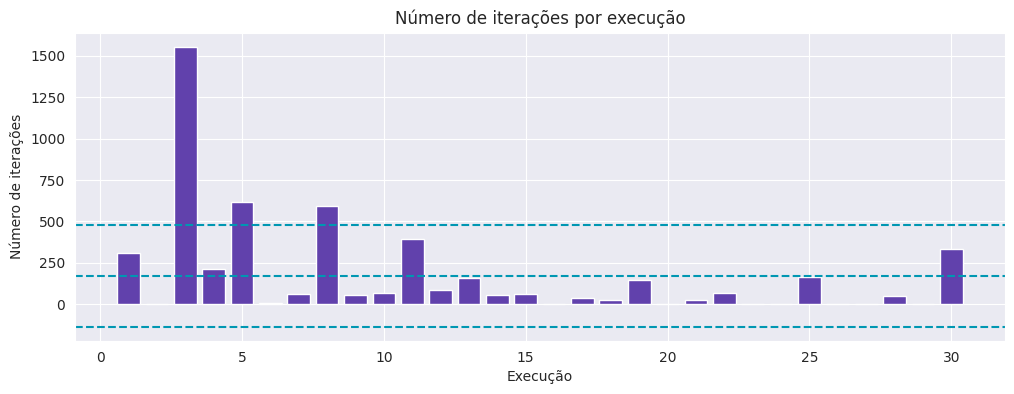

Fitness médio por execução
Média:  25.19633333333333
Desvio padrão:  1.4216996479175512


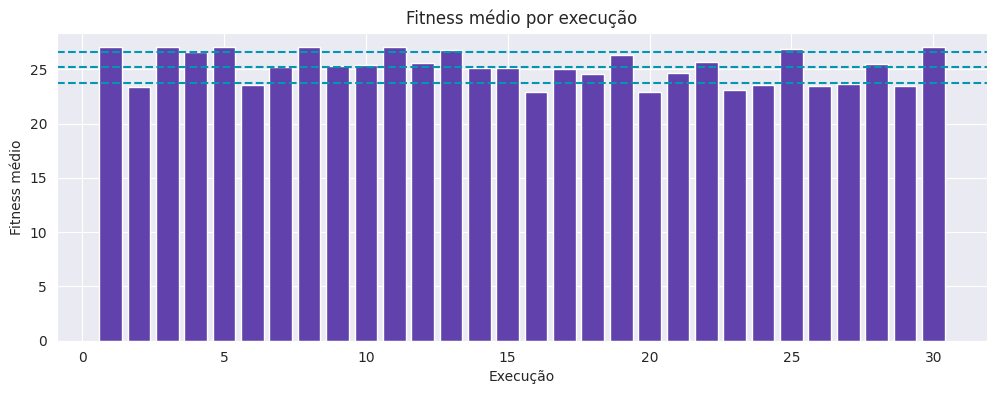

Melhor indivíduo por iteração
Média:  27.003021148036254
Desvio padrão:  0.05488187953046813


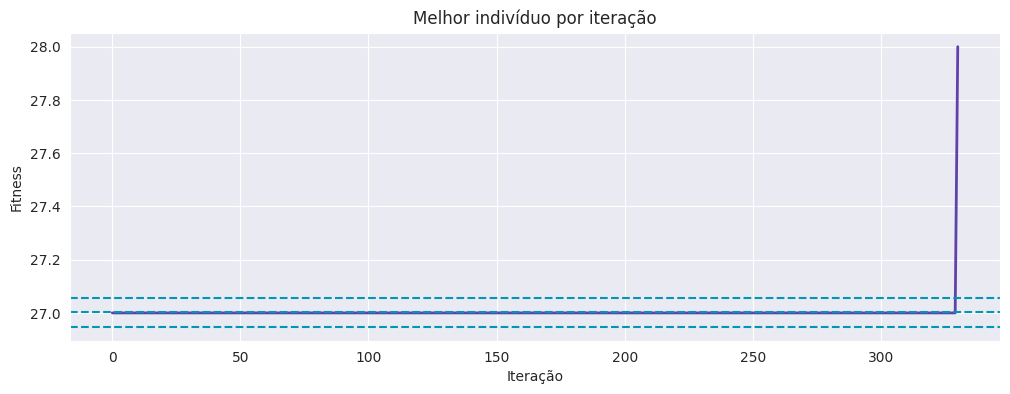

Fitness médio por iteração
Média:  25.968610271903326
Desvio padrão:  0.8701032350547815


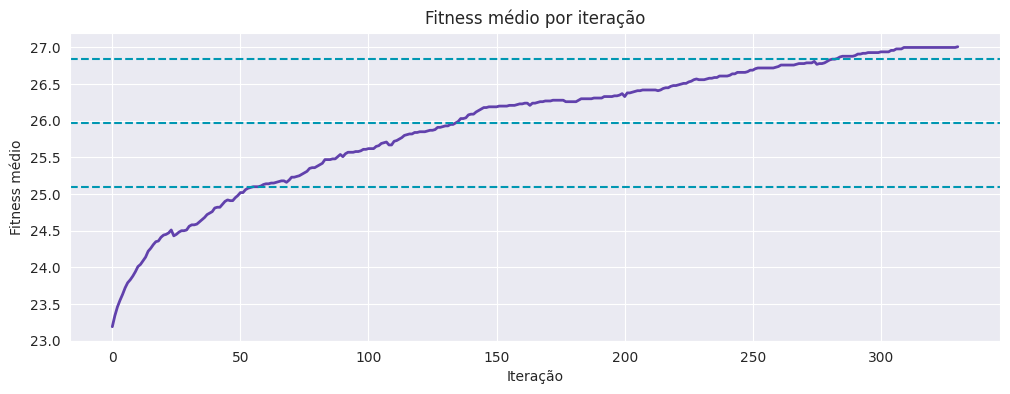

In [24]:
# Objetivo: convergencia de um indivíduo
GA(1).execute()

Número de execuções convergidas:  30
Indivíduos que convergiram por execução: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
Número de iterações por execução
Média:  445.53333333333336
Desvio padrão:  175.1946980425556


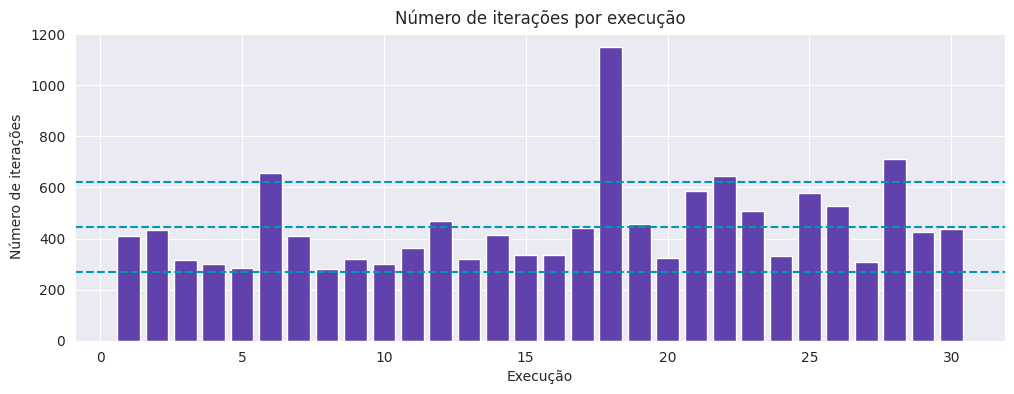

Fitness médio por execução
Média:  28.0
Desvio padrão:  0.0


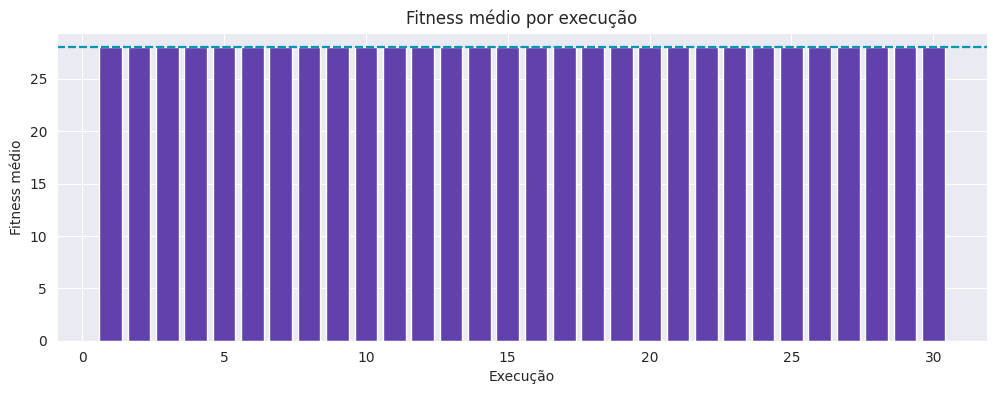

Melhor indivíduo por iteração
Média:  28.0
Desvio padrão:  0.0


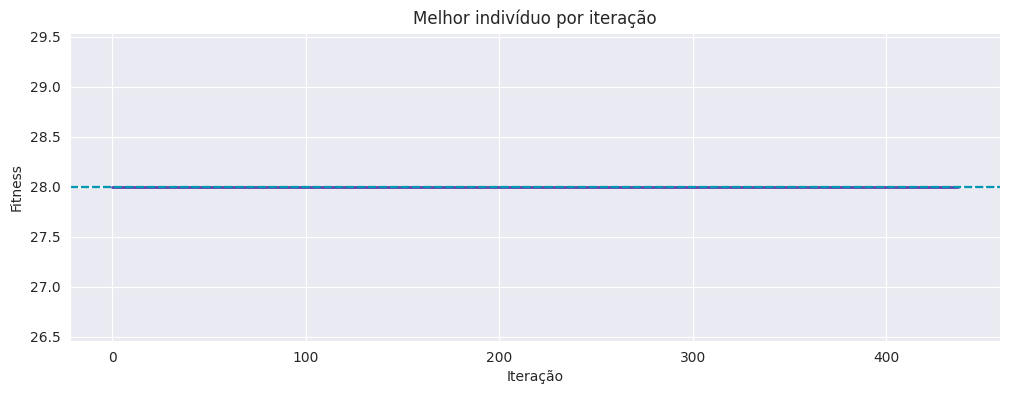

Fitness médio por iteração
Média:  26.561324200913244
Desvio padrão:  0.8467445474779994


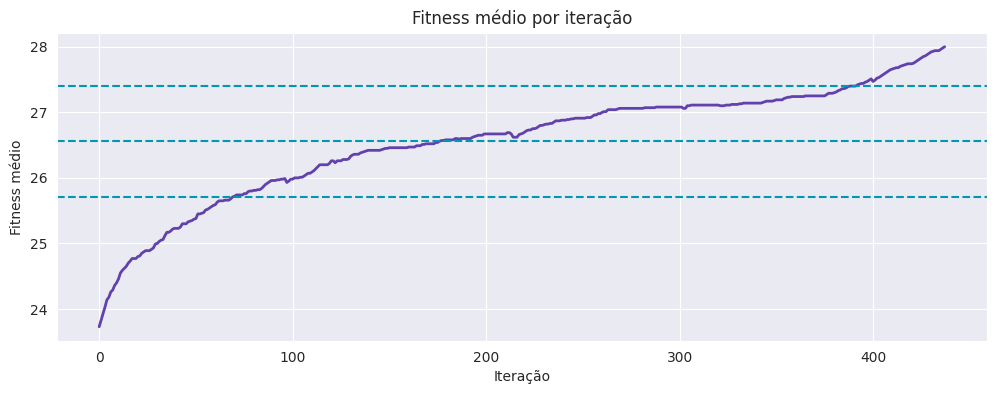

In [25]:
# Objetivo: convergencia de todos indivíduos
GA(POPULATION_SIZE).execute()

## **Parte 2**

Para a Parte 2, apenas algumas alterações foram realizadas:

- Recombinação: cruzamento de ordem 1
- Probabilidade de Mutação: 30%
- Seleção de pais: roleta
- Tamanho da população: 50
- Número de filhos gerados: 20 por iteração

In [26]:
POPULATION_SIZE = 50
MUTATION_PROBABILITY = 0.3
NUMBER_OF_CROSSOVERS = 10 # Gera 20 filhos por iteração

In [27]:
class ImprovedGA(GA):
    def __init__(self, objective):
        super().__init__(objective)

    def parents_selection(self, population):
        fitness_list = [self.fitness(individual) for individual in population]
        total_fitness = sum(fitness_list)
        probabilities = [(ind_fitness / total_fitness) for ind_fitness in fitness_list]
        selected_individuals = random.choices(population, probabilities, k=POPULATION_SIZE)
        return selected_individuals

    def crossover(self, parents):
        # Crossover com cruzamento de ordem 1
        children = []
        cross_left_point = 2
        cross_right_point = 6
        child1 = [0] * 8
        child1_idx = 6
        child2 = [0] * 8
        child2_idx = 6

        child1[cross_left_point:cross_right_point] = parents[0][cross_left_point:cross_right_point]
        for gene in parents[1]:
            if gene not in child1[cross_left_point:cross_right_point]:
                child1[child1_idx] = gene
                child1_idx = (child1_idx + 1) % 8

        child2[cross_left_point:cross_right_point] = parents[1][cross_left_point:cross_right_point]

        for gene in parents[0]:
            if gene not in child2[cross_left_point:cross_right_point]:
                child2[child2_idx] = gene
                child2_idx = (child2_idx + 1) % 8

        children += [child1, child2]

        return children

Número de execuções convergidas:  30
Indivíduos que convergiram por execução: [1, 2, 6, 2, 13, 2, 3, 1, 1, 26, 5, 3, 1, 1, 1, 1, 3, 2, 13, 18, 1, 1, 1, 3, 1, 12, 4, 1, 1, 2]
Número de iterações por execução
Média:  12.033333333333333
Desvio padrão:  10.448232173700754


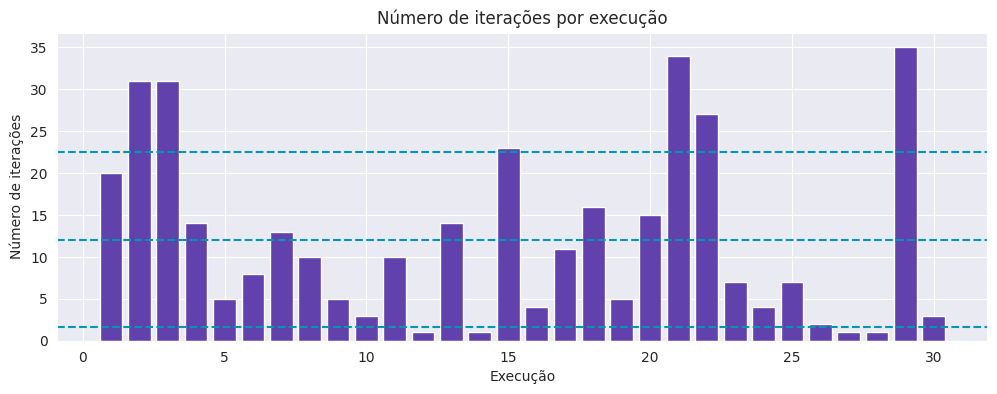

Fitness médio por execução
Média:  25.96133333333334
Desvio padrão:  0.4840918186551896


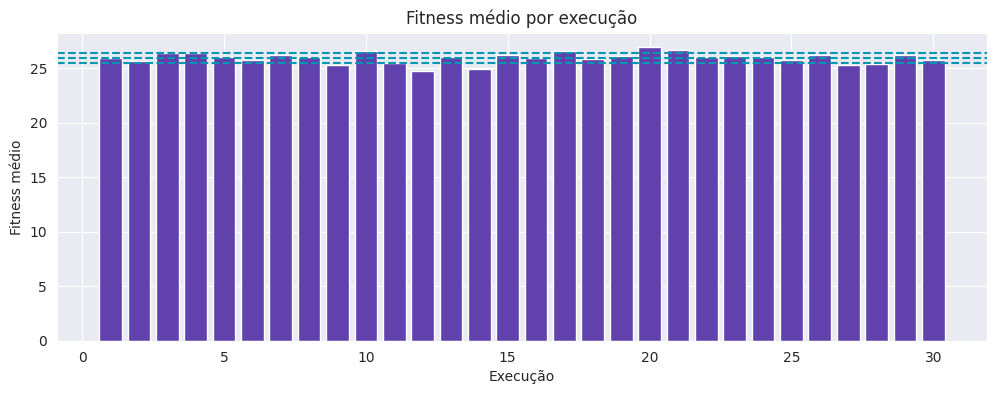

Melhor indivíduo por iteração
Média:  27.333333333333332
Desvio padrão:  0.4714045207910317


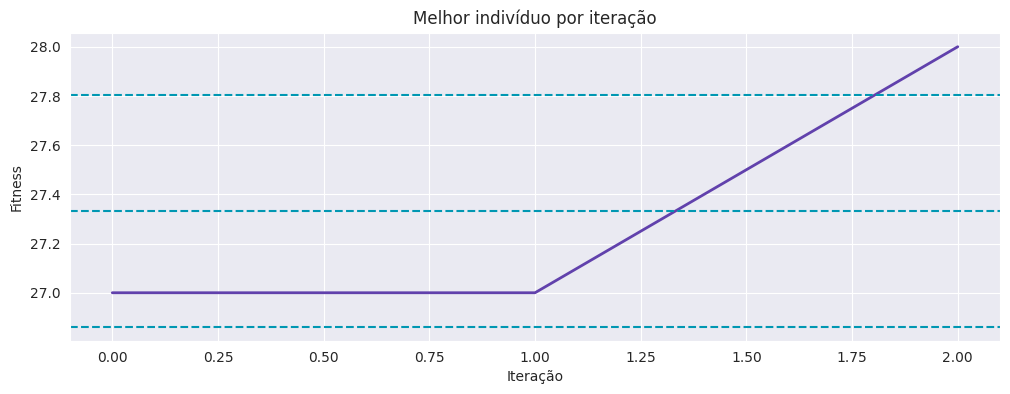

Fitness médio por iteração
Média:  25.546666666666667
Desvio padrão:  0.1892675942210454


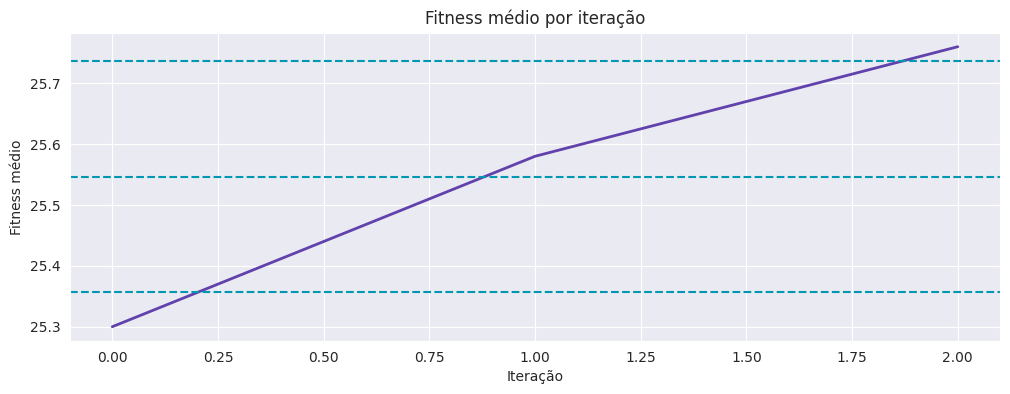

In [28]:
# Objetivo: convergencia de um indivíduo
ImprovedGA(1).execute()

Número de execuções convergidas:  29
Indivíduos que convergiram por execução: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 0, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Número de iterações por execução
Média:  1972.2333333333333
Desvio padrão:  2052.188339039302


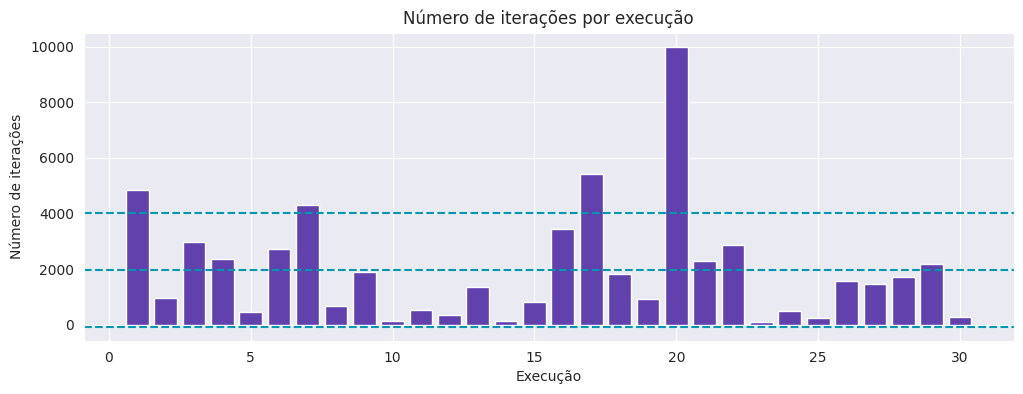

Fitness médio por execução
Média:  27.946666666666665
Desvio padrão:  0.28720878971384045


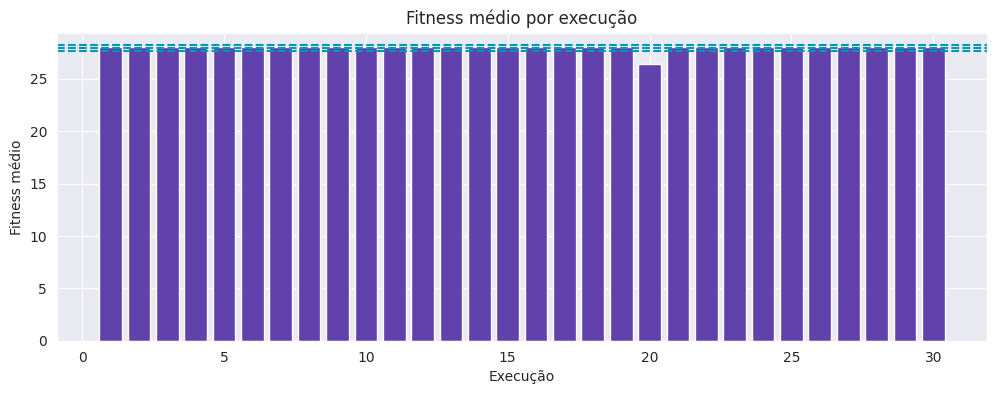

Melhor indivíduo por iteração
Média:  27.477941176470587
Desvio padrão:  0.5998395835150904


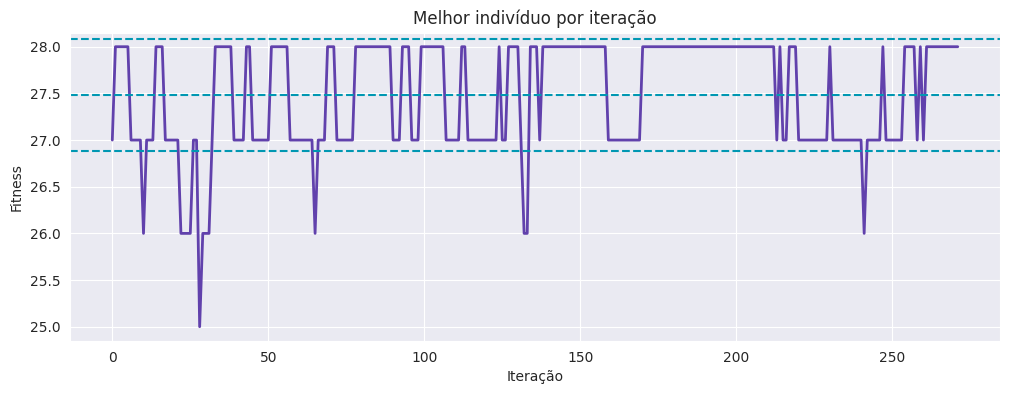

Fitness médio por iteração
Média:  26.259632352941175
Desvio padrão:  0.6288001039424159


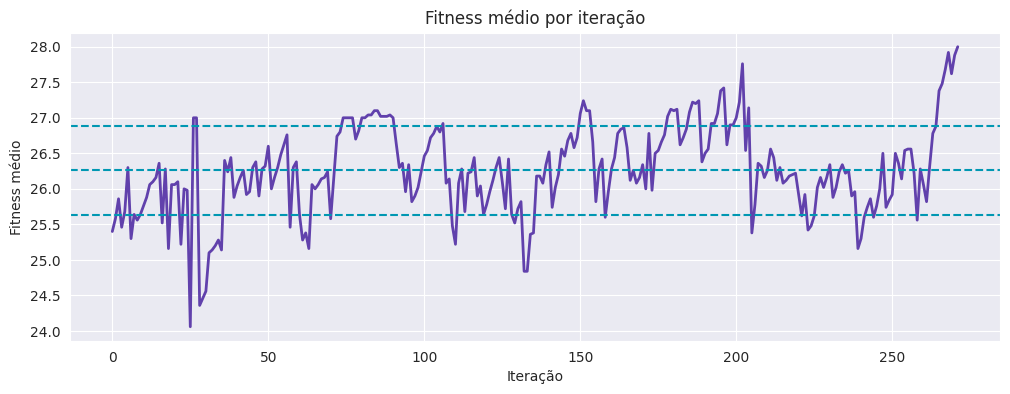

In [29]:
# Objetivo: convergencia de todos indivíduos
ImprovedGA(POPULATION_SIZE).execute()